# (updated version) Classification product based on a Deep Learning model (by fastai v2)
> **Use case**: Dog & Cat Breeds Recognizer for Veterinary Clinics

- **Author**: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou) (AI Professor at the University of Brasilia (UnB) & [AI Lab](https://ailab.unb.br/) Associate Researcher in NLP)
- **Creation date**: 10/22/2020 
- **Update date**: 04/19/2021 (see the [10/22/2020 version](https://github.com/piegu/fastai-projects/blob/master/Product_based_on_a_Deep_Learning_model_by_fastaiv2.ipynb))
- **Post in Medium**: [Product based on a Deep Learning model (by fastai v2)](https://medium.com/@pierre_guillou/product-based-on-a-deep-learning-model-by-fastai-v2-8bd3371ba11c)
- [Github folder](https://github.com/piegu/petsbreeds_voila) of the Web App v1
- [Version 1 of the Web App](https://mybinder.org/v2/gh/piegu/petsbreeds_voila/master?urlpath=%2Fvoila%2Frender%2Fpets_classifier.ipynb)

## Overview

This is the notebook of the post [Product based on a Deep Learning model (by fastai v2)](https://medium.com/@pierre_guillou/product-based-on-a-deep-learning-model-by-fastai-v2-8bd3371ba11c). 

Read this post to understand the context and objective of this notebook.

## Results

In the notebook [05_pet_breeds.ipynb](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb), the best accuray model is 94.52% (1 - the error rate which is 0.054804). 

By using all the fastai techniques tought by Jeremy Howard in the [fastai 2020 course](https://course.fast.ai/), we got **an accuracy of 95.81%**.

## 1. Initialization

In [1]:
# Import fastai v2 for computer vision
from fastai.vision.all import *
from fastai.vision.widgets import *

In [2]:
# Check for CUDA & GPU
if torch.cuda.is_available():
    print(f'gpu: {torch.cuda.current_device()} ({torch.cuda.get_device_name()})')

gpu: 0 (Tesla V100-PCIE-32GB)


## 2. Data

###  Get path to data

In [4]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/mnt/home/pierre/.fastai/data/oxford-iiit-pet/annotations'),Path('/mnt/home/pierre/.fastai/data/oxford-iiit-pet/images')]

### Display an image

2 ways to display an image from its path in a jupyter notebook.

#### PILImage.create()

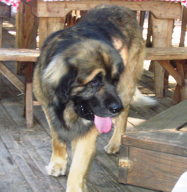

In [5]:
# Check first image
path_to_img = (path/'images').ls()[0]
img = PILImage.create(path_to_img)
img.to_thumb(192)

#### Image.open()

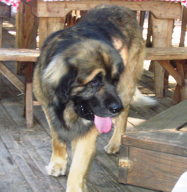

In [6]:
img = Image.open(path_to_img)
img.to_thumb(192)

### Tensor of an image

An image is a matrix of pixels with 2 (black and white) or more channels (3 for RGB). Each pixel has a number from 0 to 255.

In [7]:
# from image to tensor
tensor(img).shape

torch.Size([500, 487, 3])

In [8]:
#hide_output
img_t = tensor(img)
df = pd.DataFrame(img_t[4:15,4:22,0])
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')
df.style.set_properties(**{'font-size':'6pt'}).background_gradient()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,202,250,239,169,179,209,235,238,174,236,239,237,245,247,251,243,238,238
1,114,143,175,158,182,177,143,209,103,232,142,252,253,250,246,248,254,252
2,111,89,94,101,147,172,136,203,129,222,194,247,240,248,247,243,245,239
3,94,100,95,84,85,127,198,248,237,220,235,221,219,245,254,246,252,249
4,99,87,104,112,121,96,102,150,181,199,225,246,237,255,247,234,240,249
5,87,91,109,128,110,114,91,92,100,144,186,230,219,219,231,239,241,247
6,96,91,91,171,140,90,97,95,102,92,114,149,187,225,239,247,243,251
7,96,96,95,104,126,94,94,92,90,91,84,105,112,164,233,238,239,246
8,112,104,101,88,81,102,97,92,94,102,103,103,112,100,133,196,231,240
9,110,97,91,97,93,98,89,98,98,110,120,116,125,110,113,106,137,173


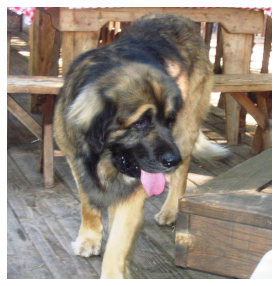

In [9]:
# from tensor to image
show_image(img_t);

## 3. Dataloaders

We will define a `DataBlock()` object using all the recent techniques (see the notebook [07_sizing_and_tta.ipynb](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb)):
- **Presizing** (notebook [05_pet_breeds.ipynb](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)).
- **Data Augmentation** with the list of transforms at batch level (`aug_transforms()`).
- **Normalization** with the standard ImageNet mean and standard deviation (`Normalize.from_stats(*imagenet_stats)`).
- **Progressive Resizing**: Gradually using larger and larger images as you train (`get_dls()`).

In [10]:
# Progressive Resizing
def get_dls(bs, size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items=get_image_files, 
                       splitter=RandomSplitter(seed=42),
                       get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                       item_tfms=RandomResizedCrop(460, min_scale=0.3),           # presizing
                       batch_tfms=[*aug_transforms(size=size, min_scale=0.75),    # data augmentation
                                   Normalize.from_stats(*imagenet_stats)])        # normalization
    return dblock.dataloaders(path/"images", bs=bs)

**Note**: The `*args` and `**kwargs` is a common idiom to allow arbitrary number of arguments to functions as described in the section more on defining functions in the Python documentation ([source](https://stackoverflow.com/questions/36901/what-does-double-star-asterisk-and-star-asterisk-do-for-parameters)).

In [10]:
# Get Dataloaders
dls = get_dls(128, 128)

In [11]:
# Check number of categories and list
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

(128, None)

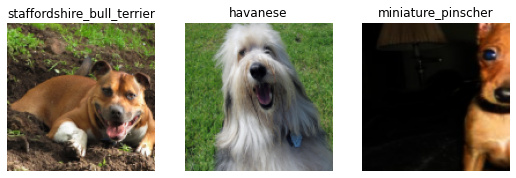

In [12]:
# Batch size and Check images in training batch
dls.bs, dls.show_batch(nrows=1, ncols=3)

(128, None)

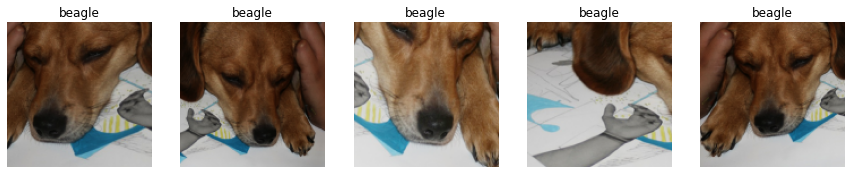

In [13]:
# Batch size and Check images in training batch
dls.bs, dls.train.show_batch(nrows=1, ncols=5, unique=True)

(128, None)

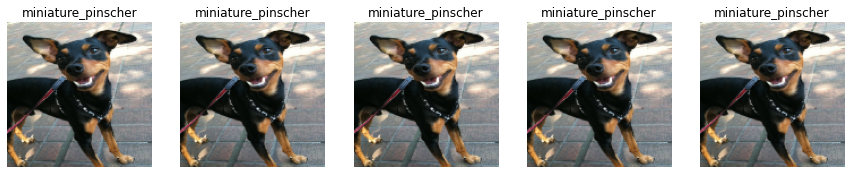

In [14]:
# Batch size and Check images in training batch
dls.bs, dls.valid.show_batch(nrows=1, ncols=5, unique=True)

## 4. First model (baseline)

To encourage our model to be less confident, we'll use `label smoothing` that will make our training more robust, even if there is mislabeled data. The result will be a model that generalizes better (see the notebook [07_sizing_and_tta.ipynb](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb)).

Let's train our model with the following fine-tuning techniques:
- **Label smoothing** in order to avoid that our model is too confident.
- **Weighted loss** in order to take into account the training dataset distribution (key point when it is unbalanced)
- **Gradual unfreezing** of layers from the last ones to the first ones.
- **Discriminative Learning Rates** (notebook [05_pet_breeds.ipynb](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)).
- **Deeper Architectures**: let's start with resnet34 as baseline, and then resnet152 as final model.

To get the validation accuracy, we will use **Test Time Augmentation (TTA)**.

### 4.1 Images of size 128

In [17]:
# Learner with model resnet34
dls = get_dls(128, 128)
model = resnet34

learn = cnn_learner(dls, model, metrics=[accuracy])

#### Weighted loss

Get the training distribution by category and visualize it.

In [12]:
from collections import Counter

# number of items by category
labels_list = [dls.train_ds[i][1].item() for i in range(len(dls.train_ds))]
count_dict = dict(Counter(labels_list).items())

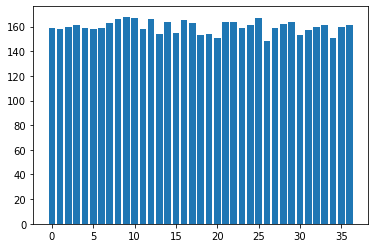

In [13]:
plt.bar(count_dict.keys(), count_dict.values())
plt.show()

Our training dataset is balanced but let's change the loss to a weighted loss in order to show how to do it.

In [14]:
trn_LabelCounts = np.array([count_dict[i] for i in range(dls.c)])
trn_weights = [1 - count/(len(dls.train_ds)) for count in trn_LabelCounts]

In [18]:
# original loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [19]:
# change the loss function
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn.loss_func = LabelSmoothingCrossEntropyFlat(weight=loss_weights)

# weighted loss function
learn.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

#### Freeze all layers but the last (new) ones

In [21]:
# Check model and frozen layers
learn.freeze()
learn.summary()

Sequential (Input shape: 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 64 x 64  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                     

We can notice that our model is frozen up to parameters group 2 but our model has how many parameters group? 

In [22]:
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

number of parameters groups: 3


For more information about parameters group, check "[How to create groups of layers and each one with a different Learning Rate?](https://github.com/piegu/fastai-projects#how-to-create-groups-of-layers-and-each-one-with-a-different-learning-rate)".

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.00363078061491251)

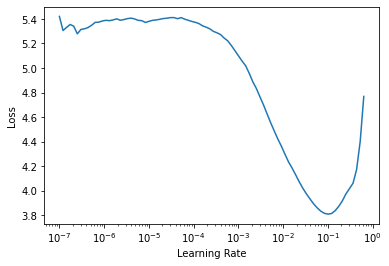

In [23]:
# Learning rate
learn.lr_find()

As only the last layers are unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (1e-2)**.

In [24]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-2
learn.fit_one_cycle(1, lr_max=lr_max)

epoch,train_loss,valid_loss,accuracy,time
0,2.320444,1.610688,0.746279,00:10


In [25]:
# Save the model
learn.save('petbreeds_1')

Path('models/petbreeds_1.pth')

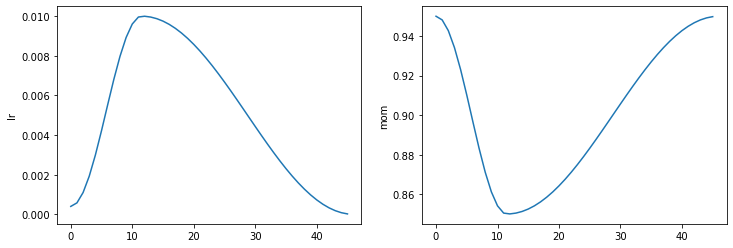

In [26]:
# Display the Learning rate and momentum values used in training
learn.recorder.plot_sched()

#### Unfreeze all layers and Discriminative Learning Rates

In [27]:
# Load model, unfreeze layers and check it
learn = learn.load('petbreeds_1')
learn.unfreeze()
learn.summary()

Sequential (Input shape: 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 64 x 64  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                     

Note: we can verify with `learn.summary()` that all parameters are unfrozen.

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=4.786300905834651e-06)

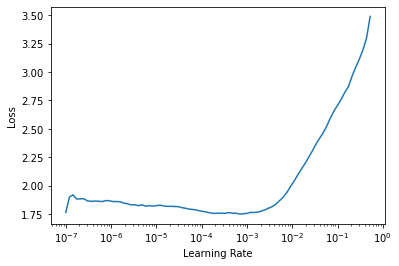

In [28]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (1e-3)** and use the **Discriminative Learning Rates** technique.

In [29]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-3
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,1.718739,1.433060,0.799053,00:11
1,1.599868,1.333921,0.820027,00:11
2,1.490716,1.292866,0.813938,00:11
3,1.400105,1.210695,0.844384,00:11
4,1.306173,1.173454,0.857916,00:11
5,1.222220,1.134675,0.867388,00:11
6,1.151358,1.127675,0.864682,00:10
7,1.110902,1.088684,0.878214,00:11
8,1.087477,1.090277,0.879567,00:11
9,1.074081,1.089503,0.876184,00:11


In [30]:
# Save the model
learn.save('petbreeds_2')

Path('models/petbreeds_2.pth')

In [31]:
# all recorded values
learn.recorder.values

[(#3) [1.7187391519546509,1.4330599308013916,0.7990527749061584],
 (#3) [1.5998684167861938,1.3339207172393799,0.8200270533561707],
 (#3) [1.4907162189483643,1.2928661108016968,0.813937783241272],
 (#3) [1.4001049995422363,1.210694670677185,0.8443843126296997],
 (#3) [1.3061734437942505,1.1734542846679688,0.8579161167144775],
 (#3) [1.2222195863723755,1.13467538356781,0.8673883676528931],
 (#3) [1.1513580083847046,1.12767493724823,0.8646820187568665],
 (#3) [1.1109017133712769,1.0886842012405396,0.8782138228416443],
 (#3) [1.0874768495559692,1.0902774333953857,0.8795669674873352],
 (#3) [1.0740807056427002,1.0895026922225952,0.8761840462684631]]

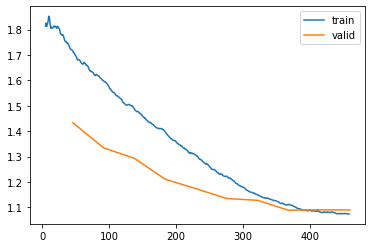

In [32]:
# Display the training and validation loss
learn.recorder.plot_loss()

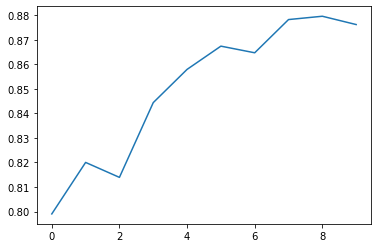

In [33]:
# Validation accuracy 
plt.plot(L(learn.recorder.values).itemgot(2));

In [34]:
# Train loss, Valid loss and accuracy of the model
learn.recorder.values[-1]

(#3) [1.0740807056427002,1.0895026922225952,0.8761840462684631]

In [35]:
# Valid accuracy of the model
print(round(learn.recorder.values[-1][-1]*100,2),'%')

87.62 %


We can visualize the model results on the validation set, too.

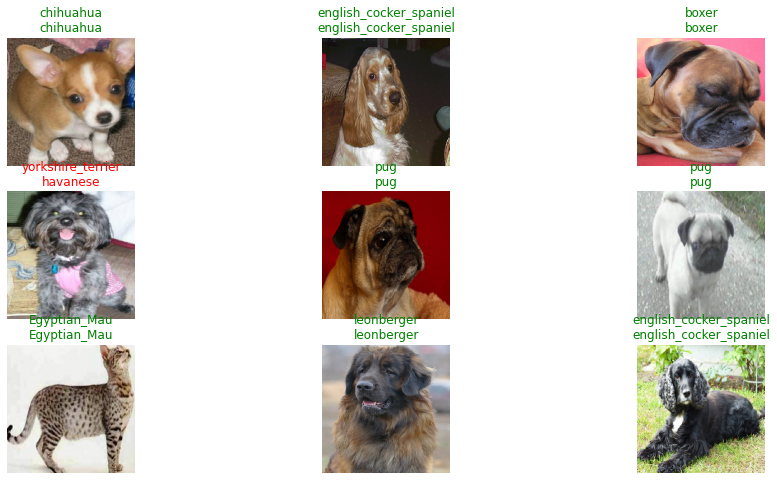

In [36]:
learn.show_results(ds_idx=1, nrows=3, figsize=(16,8))

### 4.2 Images of size 224

In [37]:
# Learner with model resnet34
dls = get_dls(64, 224)
model = resnet34
loss_func = LabelSmoothingCrossEntropyFlat(weight=loss_weights)

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])
learn = learn.load('petbreeds_2')

#### Freeze all layers but the last (new) ones

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=1.2022644114040304e-05)

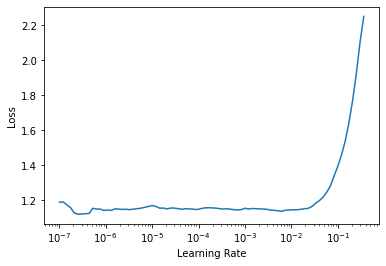

In [38]:
# Learning rate
learn.freeze()
learn.lr_find()

As only the last layers are unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (1e-3)**.

In [39]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-3
learn.fit_one_cycle(1, lr_max=lr_max)

epoch,train_loss,valid_loss,accuracy,time
0,1.099601,0.950549,0.935047,00:15


In [40]:
# Save the model
learn.save('petbreeds_3')

Path('models/petbreeds_3.pth')

#### Unfreeze all layers and Discriminative Learning Rates

In [41]:
# Load model, unfreeze layers and check it
learn = learn.load('petbreeds_3')
learn.unfreeze()

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=9.12010818865383e-07)

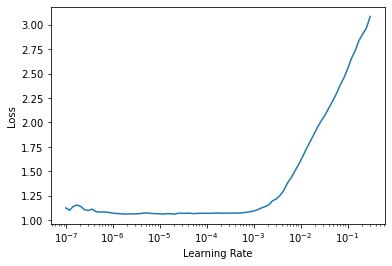

In [42]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (1e-4)**.

In [43]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-4
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,1.057191,0.946043,0.939107,00:18
1,1.047280,0.941114,0.935724,00:18
2,1.032457,0.931538,0.935724,00:18
3,1.024848,0.925354,0.938430,00:17
4,1.013020,0.923876,0.939107,00:17
5,0.998921,0.914864,0.938430,00:18
6,0.996773,0.917239,0.941137,00:18
7,0.998383,0.910425,0.945873,00:17
8,0.987399,0.909182,0.942490,00:17
9,0.980322,0.910274,0.943843,00:17


In [44]:
# Save the model
learn.save('petbreeds_4')

Path('models/petbreeds_4.pth')

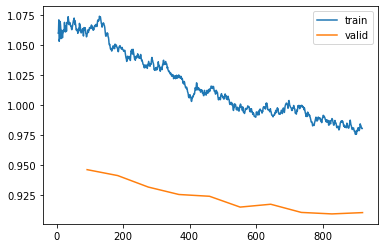

In [45]:
# Display the training and validation loss
learn.recorder.plot_loss()

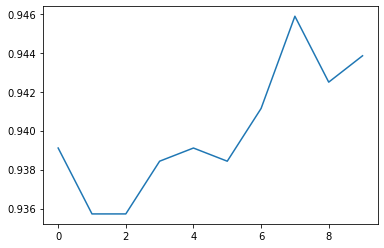

In [46]:
# Validation accuracy 
plt.plot(L(learn.recorder.values).itemgot(2));

In [47]:
# Valid accuracy of the model
print(round(learn.recorder.values[-1][-1]*100,2),'%')

94.38 %


In [48]:
# Test Time Augmentation
# notebook: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb
learn.epoch = 0
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9519621133804321

Let's keep as accuracy of our Baseline model: **95.2%**

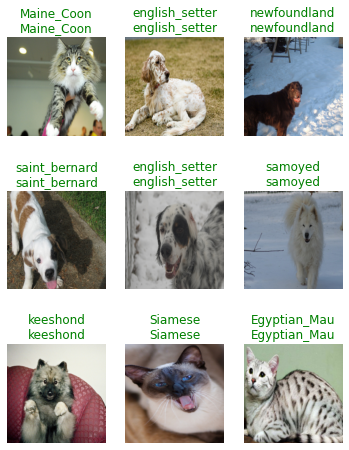

In [49]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## 5. Results analysis

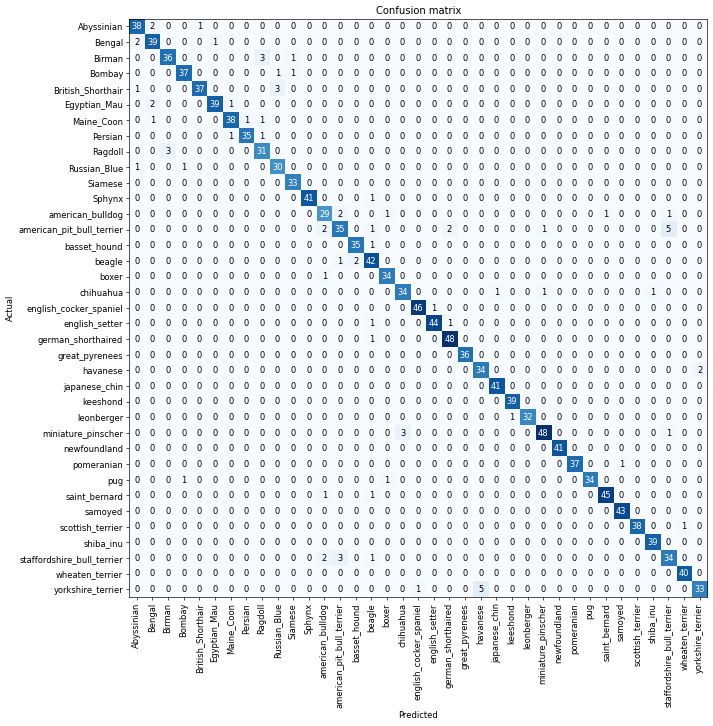

In [50]:
# Load model and display the Confusion Matrix
learn = learn.load('petbreeds_4')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [51]:
# Get categories with the most errors
interp.most_confused(min_val=3)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('yorkshire_terrier', 'havanese', 5),
 ('Birman', 'Ragdoll', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Ragdoll', 'Birman', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

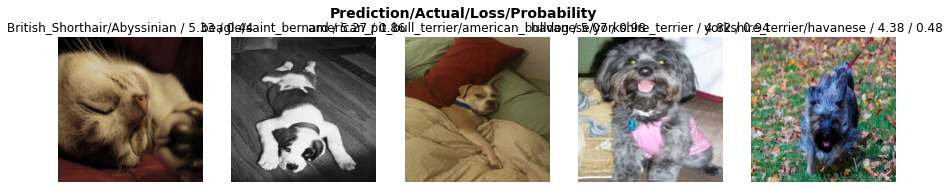

In [52]:
# Get the images with highest loss between prediction and true category
interp.plot_top_losses(5, nrows=1)

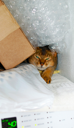

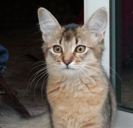

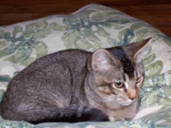

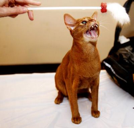

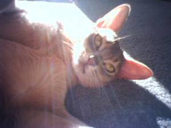

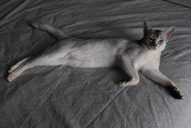

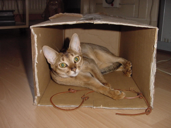

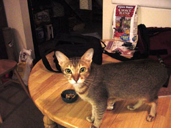

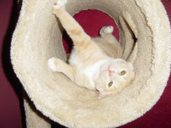

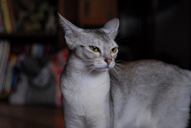

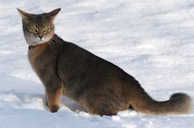

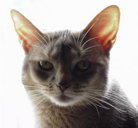

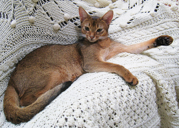

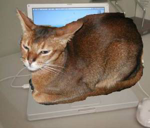

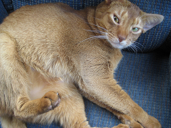

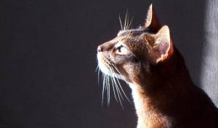

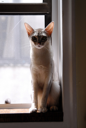

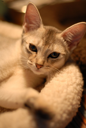

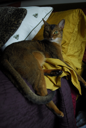

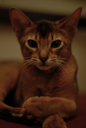

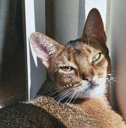

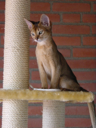

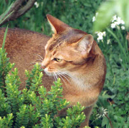

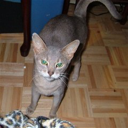

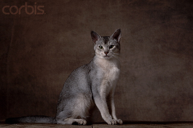

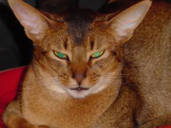

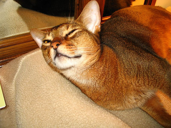

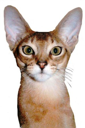

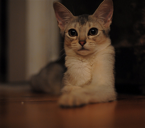

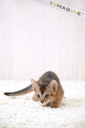

In [53]:
# # Clean training and validation datasets
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## 6. Deeper model

As we are going to use a deeper model (more parameters), let's use **half-precision floating point**, also called fp16.

### 6.1 Images of size 128

In [103]:
# Learner with model resnet152
dls = get_dls(128, 128)
model = resnet152
loss_func = LabelSmoothingCrossEntropyFlat(weight=loss_weights)

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy]).to_fp16()

#### Freeze all layers but the last (new) ones

In [104]:
# Check model and frozen layers
learn.freeze()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0008317637839354575)

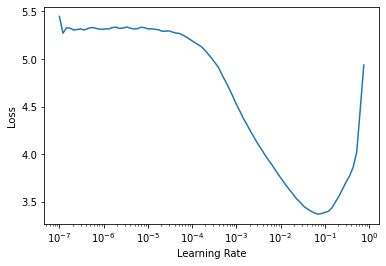

In [105]:
# Learning rate
learn.lr_find()

As only the last layers are unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (1e-2)**.

In [106]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-2
learn.fit_one_cycle(1, lr_max=lr_max)

epoch,train_loss,valid_loss,accuracy,time
0,2.055840,1.551413,0.767253,00:23


In [107]:
# Save the model
learn.save('petbreeds_5')

Path('models/petbreeds_5.pth')

#### Unfreeze all layers and Discriminative Learning Rates

In [108]:
# Load model, unfreeze layers and check it
learn = learn.load('petbreeds_5')
learn.unfreeze()

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=8.31763736641733e-06)

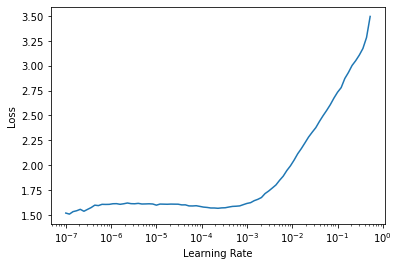

In [109]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (3e-4)**.

In [110]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 3e-4
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,1.592561,1.331430,0.813261,00:27
1,1.501528,1.270767,0.840325,00:26
2,1.409845,1.213853,0.868065,00:26
3,1.320494,1.164739,0.878890,00:26
4,1.255405,1.125084,0.883627,00:26
5,1.200109,1.108829,0.889716,00:26
6,1.157511,1.090915,0.891746,00:26
7,1.130881,1.081410,0.897835,00:28
8,1.113987,1.079198,0.892422,00:27
9,1.092011,1.075496,0.893775,00:26


In [111]:
# Save the model
learn.save('petbreeds_6')

Path('models/petbreeds_6.pth')

Deeper model accuracy: **89.38%**

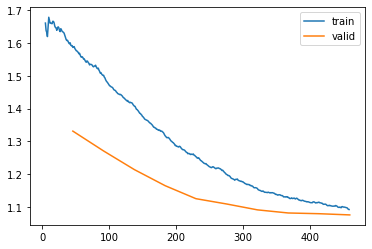

In [112]:
# Display the training and validation loss
learn.recorder.plot_loss()

### 6.2 Images of size 224

In [113]:
# Learner with model resnet152
dls = get_dls(64, 224)
model = resnet152
loss_func = LabelSmoothingCrossEntropyFlat(weight=loss_weights)

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])
learn = learn.load('petbreeds_6')
learn = learn.to_fp16()

#### Freeze all layers but the last (new) ones

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.5848931980144698e-06)

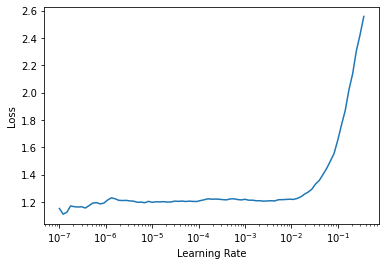

In [114]:
# Learning rate
learn.freeze()
learn.lr_find()

As only the last layers are unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (3e-3)**.

In [115]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 3e-3
learn.fit_one_cycle(1, lr_max=lr_max)

epoch,train_loss,valid_loss,accuracy,time
0,1.221586,1.005150,0.928281,00:38


In [116]:
# Save the model
learn.save('petbreeds_7')

Path('models/petbreeds_7.pth')

#### Unfreeze all layers and Discriminative Learning Rates

In [117]:
# Load model, unfreeze layers and check it
learn = learn.load('petbreeds_7')
learn.unfreeze()

SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=3.311311274956097e-06)

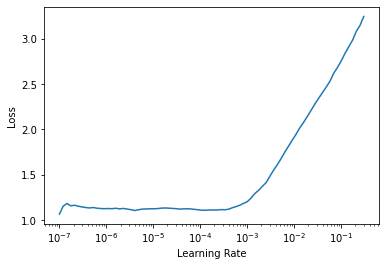

In [118]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (2e-4)**.

In [119]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-4
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,1.105926,0.968582,0.937754,00:45
1,1.075496,0.933531,0.947226,00:44
2,1.046937,0.926899,0.942490,00:45
3,1.013730,0.907083,0.946549,00:45
4,0.976070,0.908508,0.943166,00:45
5,0.947385,0.906862,0.939784,00:45
6,0.937016,0.886786,0.947226,00:44
7,0.935289,0.880373,0.947226,00:45
8,0.921850,0.871894,0.949256,00:45
9,0.905991,0.877078,0.949932,00:45


In [120]:
# Save the model
learn.save('petbreeds_8')

Path('models/petbreeds_8.pth')

In [121]:
# Test Time Augmentation
# notebook: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb
learn.epoch = 0
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9580514430999756

Deeper model accuracy: **95.81%**. Within our dataset, the use of a Deeper model does help (accuracy of our baseline model: 95.2%). 

Let's test regularization techniques in the following paragraph.

## 7. Deeper model with regularisation

In [122]:
# Learner with model resnet152
dls = get_dls(64, 224)
model = resnet152
loss_func = LabelSmoothingCrossEntropyFlat(weight=loss_weights)

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])
learn = learn.load('petbreeds_6')
learn = learn.to_fp16()

### Dropout

In [123]:
# The model has already a value of 50% of dropout
learn.model[1][7]

Dropout(p=0.5, inplace=False)

### Weight Decay

In [124]:
# Load model, unfreeze layers and check it
learn.freeze()
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

In [125]:
# let's increase weight decay from 0.01 to 0.1
wd = 0.1
# learn.opt_func = partial(Adam, sqr_mom=0.99, eps=1e-05, wd=wd, decouple_wd=True)
# learn.opt_func

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=6.918309736647643e-06)

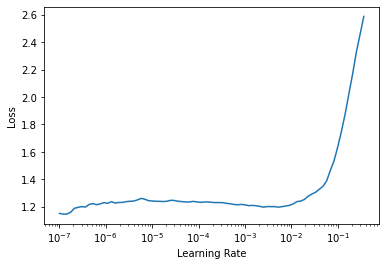

In [126]:
# Learning rate
learn.lr_find()

As only the last layers are unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (1e-3)**.

In [127]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-3
learn.fit_one_cycle(1, lr_max=lr_max, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,1.125596,0.976766,0.938430,00:33


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=1.4454397387453355e-05)

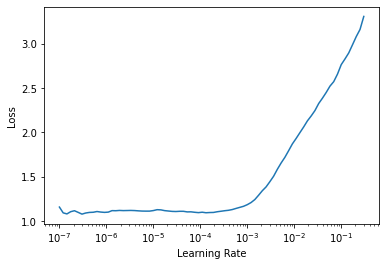

In [128]:
learn.unfreeze()
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (1e-4)**.

In [129]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-4
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max), wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,1.076274,0.958095,0.941137,00:40
1,1.074855,0.948679,0.943166,00:39
2,1.044263,0.936310,0.943166,00:40
3,1.032619,0.926702,0.945873,00:39
4,1.007785,0.918368,0.950609,00:39
5,0.997567,0.910971,0.949256,00:39
6,0.983900,0.905734,0.949932,00:40
7,0.967982,0.903170,0.950609,00:39
8,0.961769,0.900693,0.949932,00:40
9,0.966271,0.904422,0.950609,00:39


In [130]:
# Save the model
learn.save('petbreeds_9')

Path('models/petbreeds_9.pth')

In [131]:
# Test Time Augmentation
# notebook: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb
learn.epoch = 0
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9566982388496399

The accuracy did not improve. **The thing to do to improve it is certainly to get more training data ... as always with Deep Learning models!**

## 8. Export best model

According to the accuracy, **we keep our baseline model as the best one with a validation accuracy of 95.4%**.

In [88]:
# Export best model
learn = learn.load('petbreeds_8')
learn.export()

## 9. Turning your model into a Web App

Fonte: notebook [02_production.ipynb](https://github.com/fastai/fastbook/blob/master/02_production.ipynb)

In [89]:
# Get model for inference
learn_inf = load_learner('export.pkl')

### Creating a notebook App from the model

In [90]:
# Button to upload image
btn_upload = widgets.FileUpload()

# Button to classify
btn_run = widgets.Button(description='Classify')

# Display a thumb of the image
out_pl = widgets.Output()
out_pl.clear_output()

# Calculation and display of the category prediction
lbl_pred = widgets.Label()
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [91]:
# Run app
VBox([widgets.Label('Select your animal!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning your notebook into a (real) Web App

fastai explains in the notebook [02_production.ipynb](https://github.com/fastai/fastbook/blob/master/02_production.ipynb) how to create a Web App using your `export.pkl` file on a free Web service like [Binder](https://mybinder.org/) + [Voilà](https://voila.readthedocs.io/en/stable/using.html). You can as well read and apply this [Guide on how to duplicate the fastai bear_voila app on Binder](https://forum.ailab.unb.br/t/binder-and-fastai2/90/2) (if you need help about git, read this [git - the simple guide](https://rogerdudler.github.io/git-guide/)).

This is a great way for your first *well-chosen users* (parents or friends for example, or even a first client) to use your Web App, which will give you initial feedback and new data, which in turn will allow you to improve both your model and your Web App interface (this is *The Virtuous Cycle of AI* of Andrew Ng explained in the [AI Transformation Playbook](https://landing.ai/ai-transformation-playbook/)).

Of course, this free service is not sufficient for a professional Web App that you are going to develop alongside this first version. 

To do that, check the following paragraph for tips and have fun!

**Version 1 of our "Dog & Cat Breeds Recognizer for Veterinary Clinics"**
- Github: https://github.com/piegu/petsbreeds_voila
- Web App: https://mybinder.org/v2/gh/piegu/petsbreeds_voila/master?urlpath=%2Fvoila%2Frender%2Fpets_classifier.ipynb

![](https://raw.githubusercontent.com/piegu/petsbreeds_voila/master/images/webapp_v1.png)

## 10. Turning your Web App into a startup product

This paragraph is written in the post [Product based on a Deep Learning model (by fastai v2)](https://medium.com/@pierre_guillou/product-based-on-a-deep-learning-model-by-fastai-v2-8bd3371ba11c). 

## End of the notebook but about our startup product: to be continued...